In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


print(tf.__version__)

2.17.0


Primera prueba - Test de entrenamiento

In [8]:
# Parámetros
basePath = '../data'  # Ajusta la ruta si es necesario
train_dir = os.path.join(basePath, 'preprocessed', 'train')  # Ruta para entrenar
val_dir = os.path.join(basePath, 'preprocessed', 'validation')  # Ruta para validar
batch_size = 32
img_size = (224, 224)
num_classes = 1
epochs = 30

In [9]:
# Generadores de datos
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Cargar la red base preentrenada (MobileNetV2)
base_model = MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,  # No incluir la capa densa de clasificación
    weights='imagenet'  # Cargar los pesos preentrenados en ImageNet
)

# Congelar la red base (no entrenamos las capas preentrenadas)
base_model.trainable = False

# Añadir capas superiores para nuestra clasificación
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitorea la pérdida de validación
    patience=10,         # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True  # Restaura los mejores pesos al final del entrenamiento
)

# Entrenar el modelo con Early Stopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[early_stopping]
)

# Guardar el modelo entrenado
model.save('../models/reconocimiento_facial_15_personas.keras')

Found 765 images belonging to 1 classes.
Found 192 images belonging to 1 classes.
Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 265ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0000e+00  
Epoch 3/30


d:\Ing. Sistemas y Computacion\Semestre VIII\Tópicos Especiales I\VA\Reconocimiento-Facial\Reconocimiento-Facial\VA\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0000e+00  
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0000e+00  
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0000e+00  
Epoch 9/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 10/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0000e+00  
Epoch 11/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy:

Evaluacion del Modelo

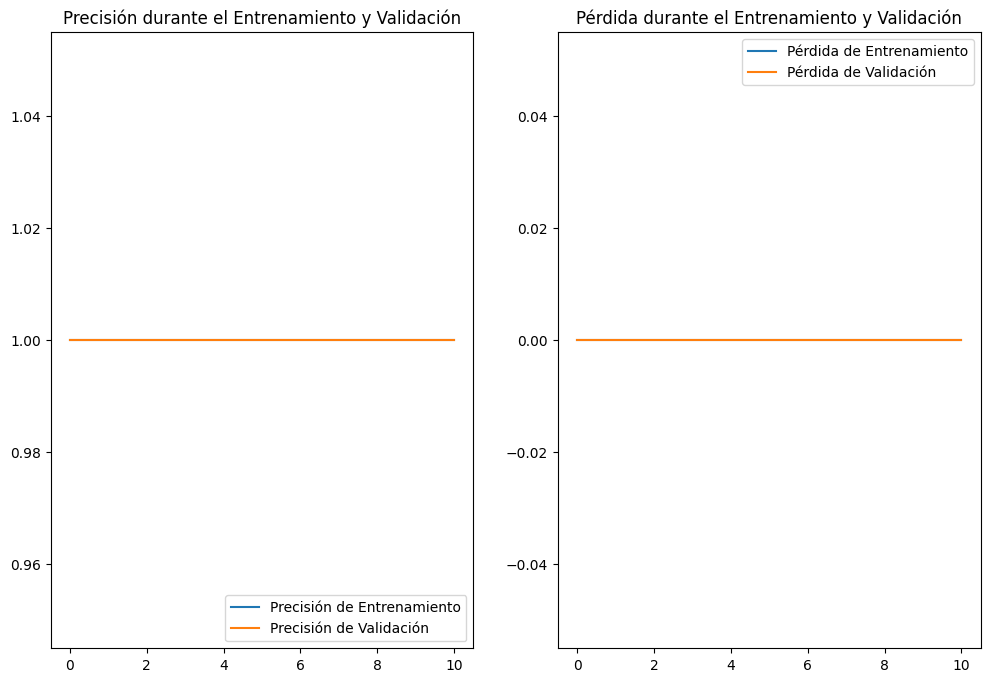

In [10]:
# Graficar el rendimiento del modelo
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Ensure all lists have the same length
    min_length = min(len(acc), len(val_acc), len(loss), len(val_loss))
    acc = acc[:min_length]
    val_acc = val_acc[:min_length]
    loss = loss[:min_length]
    val_loss = val_loss[:min_length]
    
    epochs_range = range(min_length)  # Ensure epochs_range matches the length of history data

    # Graficar la precisión
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Precisión de Entrenamiento')
    plt.plot(epochs_range, val_acc, label='Precisión de Validación')
    plt.legend(loc='lower right')
    plt.title('Precisión durante el Entrenamiento y Validación')

    # Graficar la pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Pérdida de Entrenamiento')
    plt.plot(epochs_range, val_loss, label='Pérdida de Validación')
    plt.legend(loc='upper right')
    plt.title('Pérdida durante el Entrenamiento y Validación')

    # Mostrar las gráficas
    plt.show()

# Llamar la función para graficar el rendimiento
plot_training(history)